In [2]:
# importing the tools we'll use throughout the rest of the script
# sys is system tools, should already be installed
import os

# pandas is a dataframe-managing library and it's the absolute coolest
import pandas as pd

# numpy is short for "numerical python" and it does math
import numpy as np

# seaborn is a plotting library named after a character from West Wing
# it's kind of like python's ggplot
import seaborn as sns

# nibabel handles nifti images
import nibabel as nib

# os is more system tools, should also already be installed
# we're importing tools for verifying and manipulating file paths/directories
from os.path import join, exists, isdir
from os import makedirs

# nilearn makes the best brain plots
# and their documentation/examples are so, so handy
# https://nilearn.github.io/stable/auto_examples/01_plotting/index.html
from nilearn import plotting, surface, datasets

# matplotlib is the backbone of most python plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# gridspec helps us put lots of panels on one figure
from PIL import Image

from neuromaps import transforms
from neuromaps.datasets import fetch_fslr

from gradec.utils import _zero_medial_wall

from surfplot import Plot
%matplotlib inline

In [29]:

CMAP = "Spectral_r"

def plot_surf(nii_img_thr, mask_contours=None, vmax=8, cmap=CMAP):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(
        map_lh,
        map_rh,
        space="fsLR",
        density="32k",
    )
    # midthickness

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax),
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(
            mask_lh,
            mask_rh,
            space="fsLR",
            density="32k",
        )
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, "regions", N=1)
        line_cmap = ListedColormap(["black"], "regions", N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=line_cmap,
            as_outline=True,
            cbar=False,
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )

    return p.build()

In [30]:
# Collect the three cluster NIfTI files for plotting

data_dir = "/Users/chloehampson/Desktop/abide-hb-meta/derivatives/hierarchical_clustering/k_3/nifti/"
cluster_files = [
    f"k_cluster_maps_k3_group{i}_tstat_fdr_clust_p-05_vox-50.nii.gz" for i in range(3)
    ]
cluster_paths = [os.path.join(data_dir, fname) for fname in cluster_files]

for i, path in enumerate(cluster_paths):
    print(f"Cluster {i} NIfTI: {path}")

Cluster 0 NIfTI: /Users/chloehampson/Desktop/abide-hb-meta/derivatives/hierarchical_clustering/k_3/nifti/k_cluster_maps_k3_group0_tstat_fdr_clust_p-05_vox-50.nii.gz
Cluster 1 NIfTI: /Users/chloehampson/Desktop/abide-hb-meta/derivatives/hierarchical_clustering/k_3/nifti/k_cluster_maps_k3_group1_tstat_fdr_clust_p-05_vox-50.nii.gz
Cluster 2 NIfTI: /Users/chloehampson/Desktop/abide-hb-meta/derivatives/hierarchical_clustering/k_3/nifti/k_cluster_maps_k3_group2_tstat_fdr_clust_p-05_vox-50.nii.gz


In [31]:
# fetch once
surf = datasets.fetch_surf_fsaverage()


Creating combined 3-cluster surface visualization...


NameError: name 'fig_dir' is not defined

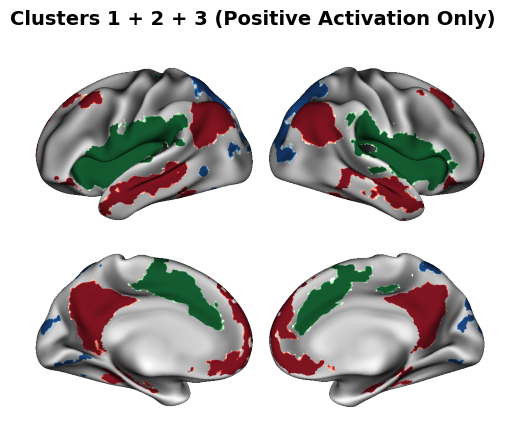

In [32]:
print("Creating combined 3-cluster surface visualization...")

# --- Surfaces & sulcal depth (fsLR-32k) ---
surfaces = fetch_fslr(density="32k")
lh, rh = surfaces["inflated"]
sulc_lh, sulc_rh = surfaces["sulc"]

# --- Load cluster volumes (assumes 3 paths in cluster_paths) ---
cluster_imgs = [nib.load(p) for p in cluster_paths]

# --- Project clusters to surface & threshold > 0 only ---
cluster_surf_data = []
for img in cluster_imgs:
    # get raw data
    data = img.get_fdata()

    # threshold to positive activation only
    data[data <= 0] = 0

    # rebuild NIfTI with thresholded data
    img_pos = nib.Nifti1Image(data, img.affine, img.header)

    # project to fsLR-32k
    cl_lh, cl_rh = transforms.mni152_to_fslr(img_pos, fslr_density="32k")
    cl_lh, cl_rh = _zero_medial_wall(cl_lh, cl_rh, space="fsLR", density="32k")

    cluster_surf_data.append((cl_lh, cl_rh))

# --- Build plot with sulc base + overlays ---
p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")

# Base layer: sulcal depth
p.add_layer({"left": sulc_lh, "right": sulc_rh},
            cmap="binary_r", cbar=False)

# Add overlays for the 3 clusters
cmaps = ["Reds", "Blues", "Greens"]  # customize if needed
for (cl_lh, cl_rh), cmap in zip(cluster_surf_data, cmaps):
    p.add_layer(
        {"left": cl_lh, "right": cl_rh},
        cmap=cmap,
        cbar=False,
        color_range=(0, 1)
    )

fig = p.build()
fig.suptitle("Clusters 1 + 2 + 3 (Positive Activation Only)",
             y=0.95, fontsize=14, fontweight="bold")

out_name = "clusters_1_2_3_posOnly_surface_plot.png"
out_path = os.path.join(fig_dir, out_name)

fig.savefig(out_path, dpi=300, bbox_inches="tight",
            facecolor="white", edgecolor="none")

print(f"✓ Saved combined cluster surface plot to {out_path}")

plt.show()


